##### This notebook contains main functionality of application
##### (For training ,data preparation etc. check out the folder. Notebooks separeted in order to maintain cleaness of code)


This notebook predicts temperature ,CO/CO2 levels  and combines sensor output from satellite. (*USA only because of datasets)
Combination of all given and predicted values generates final probability mask which will be used for detection 
of WildFire. Areas has high probabilities will be send to third model to segment fire pathces.
If fire detected and exceed the threshold values then system sends alert message to related organizations
via SMS,email and Slack notifications.

In [79]:
# These are important if you want to use communicator.

SLACK_WEBHOOK_URL=""
TWILLIO_ACCOUNT_SID=""
TWILLIO_AUTH_TOKEN=""
TWILIO_NUMBER=""
NUMBER_TO_SEND=""
WEB_APP_URL="http://18.118.198.186"

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pickle
import pandas as pd
import json
import sys
import requests
import torch
from twilio.rest import Client
import datetime
import requests
import torchvision.transforms as transform
from PIL import Image
from torchvision.utils import save_image



# This will be used final prediction.
# Ensemble technique that averages models.
def averaged_models(models,test_input):
    summa=None
    for model in models:
        if summa is None:
            summa=model.predict(test_input)
        else:
            summa+=model.predict(test_input)
    return summa/len(models)


# Downsampling block of U-Net model
class Conv_Block(torch.nn.Module):
    def __init__(self,input_ch,output_ch):
        super(Conv_Block,self).__init__()
        self.network=[]
        self.network+=[ torch.nn.Conv2d(input_ch,output_ch,3,1,padding=1) ,torch.nn.BatchNorm2d(output_ch), torch.nn.ReLU() , \
                   torch.nn.Conv2d(output_ch,output_ch,3,1,padding=1) , torch.nn.BatchNorm2d(output_ch) ,torch.nn.ReLU() ]
        self.network=torch.nn.Sequential(*self.network)
    def forward(self,input):
        return self.network(input)

# Upsampling block of U-net model
class DeConv_Block(torch.nn.Module):
    def __init__(self,input_ch,output_ch):
        super(DeConv_Block,self).__init__()
        self.network=[]
        self.network+= [ Conv_Block(input_ch,output_ch) ]
        self.network+= [ torch.nn.ConvTranspose2d(output_ch,output_ch,2,2) ] 
        self.network= torch.nn.Sequential(*self.network)
    def forward(self,input):
        return self.network(input)

# Main model that combines both downsampling and upsampling blocks
# and also has a skip connection.
class UNet(torch.nn.Module):
    def __init__(self):
        super(UNet,self).__init__()
        self.down_sample1=Conv_Block(3,64)
        self.down_sample2=Conv_Block(64,128)
        self.down_sample3=Conv_Block(128,256)
        self.down_sample4=Conv_Block(256,512)
        self.up_sample1=Conv_Block(512,512)  # 4
        self.up_sample2=DeConv_Block(1024,256) #3
        self.up_sample3=DeConv_Block(512,128) #2
        self.up_sample4=DeConv_Block(256,64) #1
        self.out=torch.nn.Sequential( Conv_Block(128,64) , torch.nn.Conv2d(64,3,1) )

    def forward(self,input):
        a1=self.down_sample1(input)
        a2=self.down_sample2(torch.nn.MaxPool2d(2,2)(a1))
        a3=self.down_sample3(torch.nn.MaxPool2d(2,2)(a2))
        a4=self.down_sample4(torch.nn.MaxPool2d(2,2)(a3))
        bootleneck=self.up_sample1(a4)
        b1=self.up_sample2( torch.cat([bootleneck,a4],1) )
        b2=self.up_sample3( torch.cat([a3,b1],1) )
        b3=self.up_sample4( torch.cat([a2,b2],1) )
        out=self.out( torch.cat([a1,b3],1) ) 
        return torch.functional.F.sigmoid(out)



# Communicator class for slack & SMS notifications
# This will send notifications to slack and text messages to mobile.
# That notification will contain url and url will be handled by webapp.
#
# Webapp endpoints used by Communicator class:
#
#                  /wildfire          -> display final report
#                  /urlshortener      -> this is important in order to make url suitable for SMS


class Communicator:
    url=SLACK_WEBHOOK_URL
    slack_data = {
        "username": "NotificationBot",
        "icon_emoji":":large_red_square:",
        #"channel" : "#somerandomcahnnel",
        "attachments": [
            {
                "color": "#9733EE",
                "fields": [
                    {
                        "title": "WildFire detected !",
                        "value": "",
                        "short": "false",
                    }
                ]
            }
            ]
          }
    @staticmethod
    def send(filename,coordinates,title="New WildFire Detected !",importance=1):
        
        msg="For detailed info about wildfire checkout : {url}"
        send_files={"image":open(filename,"rb"),"segment":open(filename.split(".")[0]+"_segmented.png","rb")}
        out=requests.post(WEB_API_URL+"/data",files=send_files)
        uid=out.json()["id"]
        
        # Send only valuable info to webapp
        url_data=f"id={uid}&datetime={datetime.datetime.now().strftime('%Y-%m-%d;%H:%M:%S')}&latitude={coordinates[0]}&longitude={coordinates[1]}"
        URL=WEB_APP_URL+f"/wildfire?{url_data}"
        
        shortener_id=requests.post(WEB_APP_URL+f"/urlshortener",params={"url":URL}).json()["id"]
        shortener_url=WEB_APP_URL+f"/urlshortener?id={shortener_id}"
        
        msg=msg.format(url=shortener_url)
        
        Communicator.slack_data["attachments"][0]["fields"][0]["value"]=msg
        Communicator.slack_data["attachments"][0]["fields"][0]["title"]=title
       
        byte_length = str(sys.getsizeof(Communicator.slack_data))
        headers = {'Content-Type': "application/json", 'Content-Length': byte_length}
        response = requests.post(Communicator.url, data=json.dumps(Communicator.slack_data), headers=headers)
        
        if(response.status_code!=200):
            print("Something went wrong Slack hook doesnt work!")
        
        
        # send SMS message  
        client = Client(TWILLIO_ACCOUNT_SID, TWILLIO_AUTH_TOKEN)
        
        client.messages \
                .create(
                     body=msg,
                     from_=TWILIO_NUMBER,
                     to=NUMBER_TO_SEND
                 )

In [112]:
# Load trained temperature predictor models

adab_temp_reg=sc = pickle.load(open('adaboost.pkl','rb'))
random_temp_reg = pickle.load(open("randomforest.pkl","rb"))
#extra_temp_reg= pickle.load(open("extratree.pkl","rb"))
gradient_temp_reg=pickle.load(open("gradientboost.pkl","rb"))
xgb_temp_reg=pickle.load(open("xgboost.pkl","rb"))
#nn_temp_pipe=pickle.load(open("fullyconnected.pkl","rb"))


# Load trained CO/CO2 predictor models

adab_CO_reg=sc = pickle.load(open('EPA_adaboost.pkl','rb'))
random_CO_reg = pickle.load(open("EPA_randomforest.pkl","rb"))
#extra_CO_reg= pickle.load(open("EPA_extratree.pkl","rb"))
gradient_CO_reg=pickle.load(open("EPA_gradientboost.pkl","rb"))
xgb_CO_reg=pickle.load(open("EPA_xgboost.pkl","rb"))
#nn_CO_pipe=pickle.load(open("EPA_fullyconnected.pkl","rb"))

In [119]:
test_data=pd.read_csv('test_me.csv')  # contains coordinates,measured temperature,date/time,CO level,radiation levels.



# Save radiation values it will be usefull in further processing.
radiation=test_data['radiation']
temperature=test_data['temperature']
CO=test_data['CO']

test_data.drop(['radiation','temperature','CO'],axis=1,inplace=True)

CO_test=test_data[["latitude","longitude","year","month","day"]]
TEMP_test=test_data[["longitude","latitude","specific_humidty","month","year","day"]]


In [120]:
CO_test.head()

,latitude,longitude,year,month,day
0,-95.141667,49.4,2022,2,7
1,-95.100000,49.4,2022,2,7
2,-95.058333,49.4,2022,2,7
3,-95.016667,49.4,2022,2,7
4,-94.975000,49.4,2022,2,7


In [121]:
TEMP_test.head()

,longitude,latitude,specific_humidty,month,year,day
0,49.4,-95.141667,0.00241,2,2022,7
1,49.4,-95.100000,0.00241,2,2022,7
2,49.4,-95.058333,0.00241,2,2022,7
3,49.4,-95.016667,0.00242,2,2022,7
4,49.4,-94.975000,0.00242,2,2022,7


In [171]:
predicted_temperature=averaged_models([adab_temp_reg,random_temp_reg,gradient_temp_reg,xgb_temp_reg],TEMP_test)
predicted_CO=averaged_models([adab_CO_reg,random_CO_reg,gradient_CO_reg,xgb_CO_reg],CO_test)


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- latitude
- longitude
- specific_humidty
Feature names seen at fit time, yet now missing:
- lat
- lon
- specific_humidity

  warnings.warn(message, FutureWarning)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- latitude
- longitude
- specific_humidty
Feature names seen at fit time, yet now missing:
- lat
- lon
- specific_humidity

  warnings.warn(message, FutureWarning)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during

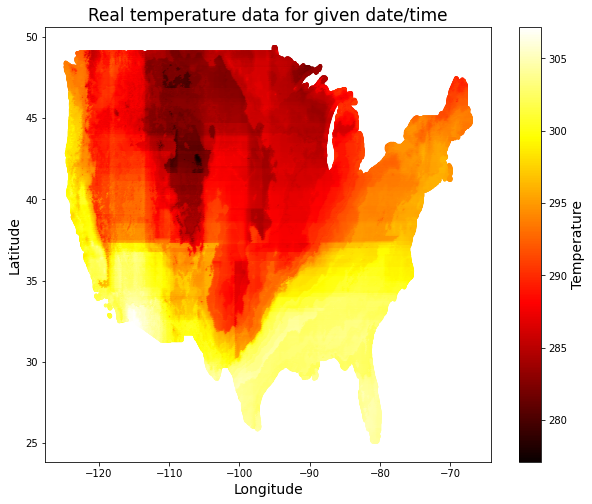

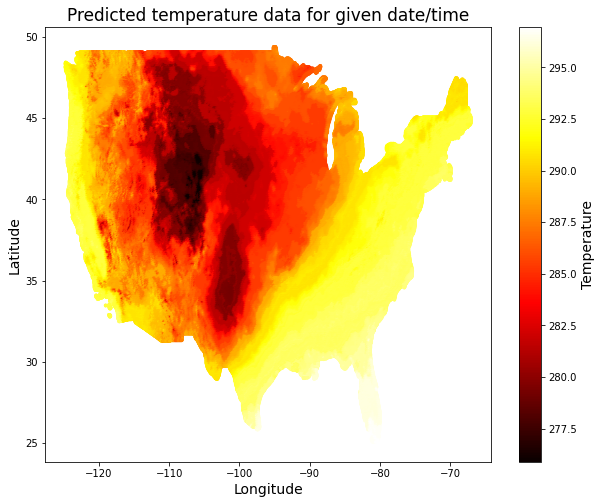

In [123]:
# PLOTS Temperature

plt.figure(figsize = (10,8))
plt.scatter(test_data.latitude, test_data.longitude ,c=temperature, cmap ='hot', s=5)
plt.colorbar().set_label('Temperature', fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.title('Real temperature data for given date/time', fontsize=17)
plt.show()


plt.figure(figsize = (10,8))
plt.scatter(test_data.latitude, test_data.longitude ,c=predicted_temperature, cmap ='hot', s=5)
plt.colorbar().set_label('Temperature', fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.title('Predicted temperature data for given date/time', fontsize=17)
plt.show()

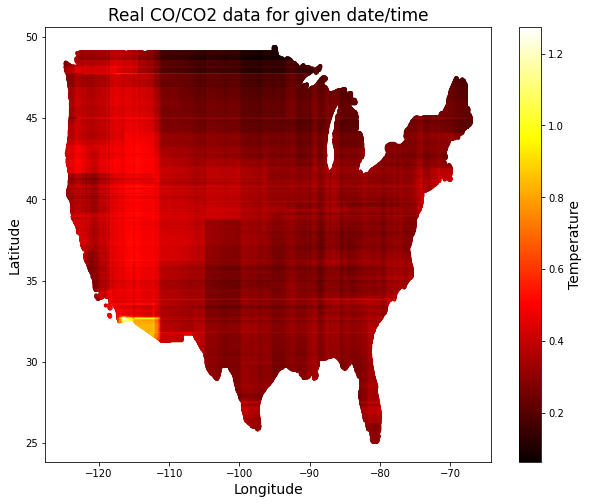

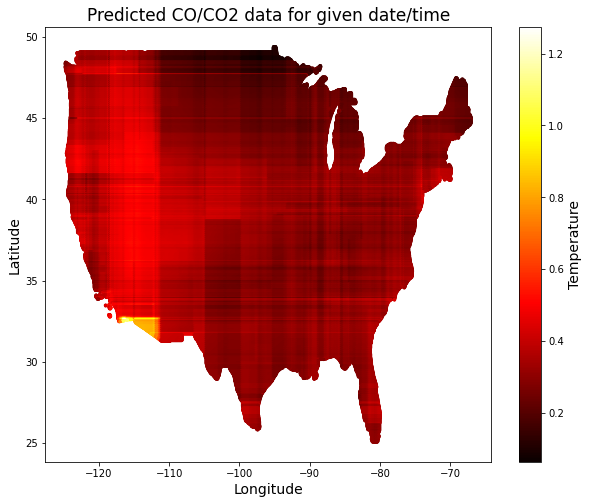

In [170]:
# PLOTS CO/CO2 level

plt.figure(figsize = (10,8))
plt.scatter(test_data.latitude, test_data.longitude ,c=CO, cmap ='hot', s=5)
plt.colorbar().set_label('Temperature', fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.title('Real CO/CO2 data for given date/time', fontsize=17)
plt.show()


plt.figure(figsize = (10,8))
plt.scatter(test_data.latitude, test_data.longitude ,c=predicted_CO, cmap ='hot', s=5)
plt.colorbar().set_label('Temperature', fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.title('Predicted CO/CO2 data for given date/time', fontsize=17)
plt.show()

In [172]:
# Subtract here real and predicted values to get the difference.
# These difference values will be used for final prediction.
# FINAL_PREDICTION=0.3*(TEMPERATURE-PREDICTED_TEMPERATURE)+0.3*(CO-PREDICTED_CO)+0.4*(RADIATION)
# This formula consider fact that downward surface radiation has most impact on final prediction
# Beause of its high fire risk index property.  

delta_CO=np.array(CO)-predicted_CO
delta_TEMP=np.array(temperature)-predicted_temperature
delta_RAD=np.array(radiation)

def normalize(data):
    return (data - np.min(data))/(np.ptp(data)+0.0000001)

final_prediction=0.3*normalize(delta_TEMP)+0.3*normalize(delta_CO)+0.4*normalize(radiation)

mean_final=np.mean(final_prediction)

final_df=test_data[["latitude","longitude"]]
final_df["final_prediction"]=final_prediction

# Select areas that has above the average wildfire probability.
# Select only above threshold confidence rate
threshold=0.85
final_coordinates=final_df.loc[ final_df["final_prediction"]>threshold ]


/tmp/ipykernel_65/3260637553.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["final_prediction"]=final_prediction


In [173]:
final_coordinates

,latitude,longitude,final_prediction
423468,-116.433333,32.608333,0.854448
423469,-116.391667,32.608333,0.855045
423470,-116.350000,32.608333,0.850656
423471,-116.308333,32.608333,0.852109
423472,-116.266667,32.608333,0.859327
423473,-116.225000,32.608333,0.851871
423474,-116.183333,32.608333,0.857554
423475,-116.141667,32.608333,0.857179
423476,-116.100000,32.608333,0.852841
423489,-115.558333,32.608333,0.850085


In [174]:
# Combine similiar set of points to just one

def combine_points(data):
    if(len(data)==0):
        return []
    
    base_lat,base_lon=data[0][0],data[0][1]
    center_coordinates=[(base_lat,base_lon)]
    
    for lat,lon,_ in data[1:]:
        distance=np.sqrt( (base_lat-lat)*(base_lat-lat)+(base_lon-lon)*(base_lon-lon) )
        if(distance>20):
            center_coordinates.append((lat,lon))        
    return center_coordinates


lon_lat=combine_points(np.array(final_coordinates))

[(-116.4333333, 32.60833333)]

In [175]:
# Lets get image from satellite for given coordinates (static image)

img=requests.get(WEB_APP_URL+"/getphoto?longitude=x&langitude=y")
with open("test.png","wb") as f:
    f.write(img.content)

In [176]:
# Lets prepare given satellite image for segmentation

transformation=transform.Compose([transform.Resize((256,256)) ,transform.ToTensor(),transform.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))])
test=Image.open("test.png").convert('RGB')
transformed=transformation(test).float().unsqueeze_(0)


In [177]:
network=UNet()
network.load_state_dict(torch.load("unet.pth",map_location=torch.device('cpu')))

network.eval()
output=network(transformed)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [178]:
save_image(output,"test_segmented.png")

In [179]:
# Send notfication 
Communicator.send("test.png",lon_lat[0])